In [85]:
import itertools
import json
import os
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics

from database import data_utils

import importlib
importlib.reload(data_utils)

RUN_FOLDER = "../results/3_mo_cross_val/"

In [86]:
# # Read in DeepTTE files
# kcm_deeptte_results = pd.read_csv(
#     RUN_FOLDER+"kcm/deeptte_results/result/deeptte.res",
#     header=None,
#     names=["Fold","Epoch","Test File","DTTE Loss","MAPE","RMSE","MAE"],
#     dtype={"Fold": int, "Epoch": int, "Test File": str, "DTTE Loss": float, "MAPE": float, "RMSE": float, "MAE": float}
# )
# kcm_deeptte_results['City'] = "Seattle"
# kcm_deeptte_results['Model'] = "DeepTTE"
# kcm_deeptte_result_df = kcm_deeptte_results[kcm_deeptte_results['Test File']=="test"]
# kcm_deeptte_result_df = kcm_deeptte_result_df[['Model','City','Fold','MAPE','RMSE','MAE']].copy()

# atb_deeptte_results = pd.read_csv(
#     RUN_FOLDER+"atb/deeptte_results/result/deeptte.res",
#     header=None,
#     names=["Fold","Epoch","Test File","DTTE Loss","MAPE","RMSE","MAE"],
#     dtype={"Fold": int, "Epoch": int, "Test File": str, "DTTE Loss": float, "MAPE": float, "RMSE": float, "MAE": float}
# )
# atb_deeptte_results['City'] = "Trondheim"
# atb_deeptte_results['Model'] = "DeepTTE"
# atb_deeptte_result_df = atb_deeptte_results[atb_deeptte_results['Test File']=="test"]
# atb_deeptte_result_df = atb_deeptte_result_df[['Model','City','Fold','MAPE','RMSE','MAE']].copy()


# kcm_deeptte_results = pd.read_csv(
#     RUN_FOLDER+"kcm/deeptte_results/result/deeptte.res",
#     header=None,
#     delimiter=" ",
#     names=["Label","Pred"],
#     dtype={"Label": float, "Pred": float}
# )
# kcm_deeptte_results
# mape = metrics.mean_absolute_percentage_error(kcm_deeptte_results['Label'], kcm_deeptte_results['Pred'])
# rmse = np.sqrt(metrics.mean_squared_error(kcm_deeptte_results['Label'], kcm_deeptte_results['Pred']))
# mae = metrics.mean_absolute_error(kcm_deeptte_results['Label'], kcm_deeptte_results['Pred'])
# kcm_deeptte_result_df = pd.DataFrame({
#     "Model": "DeepTTE",
#     "City": "Seattle",
#     "Fold": 0,
#     "MAPE": mape,
#     "RMSE": rmse,
#     "MAE": mae
# }, index=[0])
# kcm_deeptte_result_df

In [87]:
kcm_model_results = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "model_results.pkl")
atb_model_results = data_utils.load_pkl(RUN_FOLDER + "atb/" + "model_results.pkl")
kcm_result_df, kcm_loss_df = data_utils.extract_results("Seattle", kcm_model_results)
atb_result_df, atb_loss_df = data_utils.extract_results("Trondheim", atb_model_results)
model_performances_df = pd.concat([kcm_result_df, atb_result_df], axis=0)
model_curves_df = pd.concat([kcm_loss_df, atb_loss_df], axis=0)

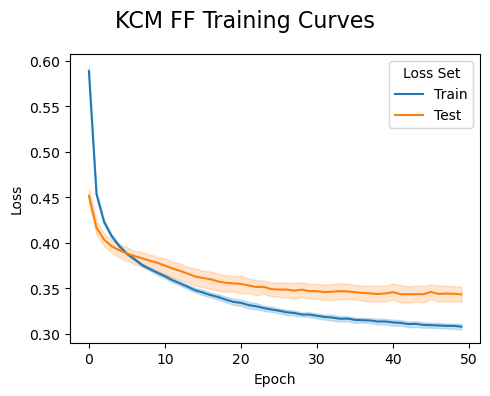

In [88]:
plot_data = model_curves_df[model_curves_df['City']=="Seattle"]
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('KCM FF Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_seattle.png", dpi=1800, bbox_inches='tight')

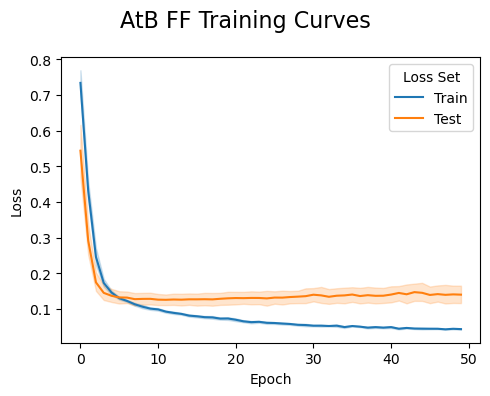

In [89]:
plot_data = model_curves_df[model_curves_df['City']=="Trondheim"]
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('AtB FF Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_trondheim.png", dpi=1800, bbox_inches='tight')

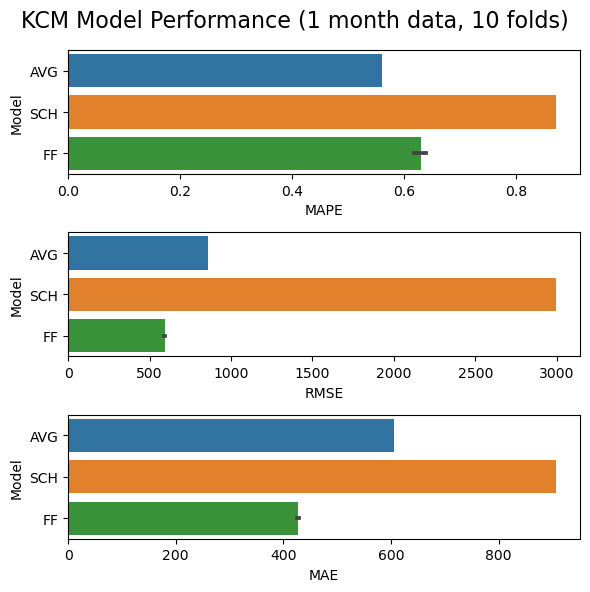

In [90]:
plot_data = model_performances_df[model_performances_df['City']=="Seattle"]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
fig.suptitle('KCM Model Performance (1 month data, 10 folds)', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_seattle.png", dpi=1800, bbox_inches='tight')

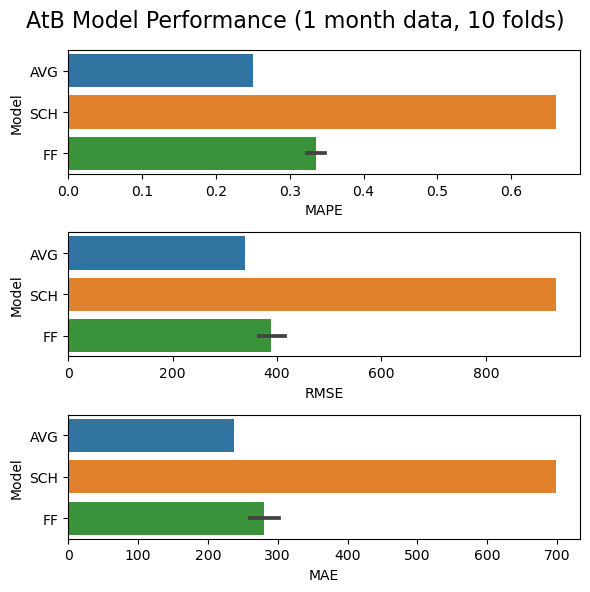

In [91]:
plot_data = model_performances_df[model_performances_df['City']=="Trondheim"]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
fig.suptitle('AtB Model Performance (1 month data, 10 folds)', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_trondheim.png", dpi=1800, bbox_inches='tight')